In [1]:
import math
import torch
from torch import nn
from torch import Tensor
from torch.nn  import functional as F
import gpytorch
from matplotlib import pyplot as plt
from torch.distributions.multivariate_normal import MultivariateNormal
import matplotlib.cm as cm
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D 
import sys
from decimal import Decimal
from IPython.display import clear_output
sys.path.append("..")
from LBFGS import FullBatchLBFGS
from kernels import vvkernels as vvk, sep_vvkernels as svvk, vvk_rbfkernel as vvk_rbf
from means import vvmeans as vvm
from likelihood import vvlikelihood as vvll
from mlikelihoods import MarginalLogLikelihood as exmll
from predstrategies import GPprediction
from utils import ObjFun, get_vertices, stopping_criteria
from scipy import stats
import numpy as np
import seaborn as sns
import scipy
%matplotlib inline
%load_ext autoreload
%autoreload 2

# If model is bad, initialize at previous 2 sample!!!

In [2]:
sns.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=30)     # fontsize of the axes title
plt.rc('axes', labelsize=28)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=24)    # fontsize of the tick labels
plt.rc('ytick', labelsize=24)    # fontsize of the tick labels
plt.rc('legend', fontsize=24)    # legend fontsize
plt.rc('font', size=24)          # controls default text sizes


# Objective function

We sample from $$V_1(x_1, x_2) = 3(1 - x_1)^2 e^{-x_1^2 - (x_2 +1)^2} - 10 (x_1/5 - x_1 ^3 - x_2^5) e^{-x_1^2 - x_2 ^2} - 3 e^{- (x_1 + 2) ^2 - x_2^2} + 0.5(2x_1 + x_2)$$
$$V_2(x_1, x_2) = 3(1 +x_2)^2 e^{-x_2^2 - (x_1 +1)^2} - 10 (-x_2/5 + x_2 ^3 + x_1^5) e^{-x_1^2 - x_2 ^2} - 3 e^{- ( 2- x_2) ^2 - x_1^2} + 0.5(2x_1 + x_2)$$

where $(x_1, x_2) \in [-3, 3]^2$

In [3]:
torch.set_default_dtype(torch.float64)

In [4]:
vf = ObjFun()
f_target = vf.tgt_vec
print(f_target)
sample_size = 4
D = vf.D
N = vf.N

vf.low = -3.
vf.high = 3.

high_minus_low = vf.high- vf.low
#high_minus_low = -
def g_theta(sample_size, D):
    loc_x = (2. - 1.0 )  * np.random.random_sample((sample_size,1)) + 1.0
    
    loc_y = (2.  -1.0)  * np.random.random_sample((sample_size,1)) - 2.
    loc = np.concatenate((loc_x, loc_y), 1)
    #loc = high_minus_low  * np.random.random_sample((sample_size,2)) + vf.low#(np.random.uniform(low=vf.low, high=vf.high, size=(sample_size, D)))
    return Tensor(loc)
train_x = g_theta(sample_size, D)
#train_x = Tensor([[-1.5, 1.5], [-1.5, 1.3]])
print(train_x)
noise_value = 0.0004 #noise_free = 0.
def vfield_(x):
    x = x.reshape(x.shape[0],D)
    out = torch.zeros(x.shape[0], N)
    
    out = vf(x[:,0], x[:,1]) + torch.randn(Tensor(vf(x[:,0], x[:,1])).size()) * math.sqrt(noise_value)
    return out #/torch.max(out)

train_y = vfield_(train_x)

# print(train_y)
# train_y = (train_y - train_y.mean())/train_y.std(dim=-2, keepdim=True)
# train_x = (train_x - train_x.mean())/train_x.std(dim=-2, keepdim=True)
# print(train_y)
# print(train_y.std(dim=-2, keepdim=True))



tensor([0.3380, 0.3502], dtype=torch.float32)
tensor([[ 1.4765, -1.2128],
        [ 1.4850, -1.9247],
        [ 1.9016, -1.8572],
        [ 1.8859, -1.3426]])


In [5]:
0.0779/ 0.0305


2.5540983606557375

## GP model initialization
We inialize the GP model following https://docs.gpytorch.ai/en/stable/examples/03_Multitask_Exact_GPs/Multitask_GP_Regression.html

In [6]:
x_train = train_x #loc #torch.linspace(0, 1, 10)
y_train = train_y #v  #torch.stack([torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,torch.cos(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,], -1)

class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood,num_base_kernels):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        a = torch.ones(2,2)
        chol_q = torch.tril(a)
        self.mean_module = vvm.TensorProductSubMean(gpytorch.means.LinearMean(2), num_tasks = 2)  #vvm.TensorProductSubMean(gpytorch.means.LinearMean(2), num_tasks = 2)#vvm.TensorProductSubMean(gpytorch.means.ConstantMean(), num_tasks = 2)  # 
        base_kernels = []
        for i in range(num_base_kernels):
            base_kernels.append(gpytorch.kernels.ScaleKernel(( gpytorch.kernels.RBFKernel() ))) #gpytorch.kernels.PolynomialKernel(4)  ##gpytorch.kernels.MaternKernel()# (vvk_rbf.vvkRBFKernel())
 
            
        self.covar_module = svvk.SepTensorProductKernel(base_kernels,num_tasks = 2)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)
    
    



# Hyperparamaters oprimization

In [7]:
# # ###hyperparameters optimization###
def hyper_opti(g_theta1, agg_data, training_iter,num_base_kernels,noise_value, current_model = None, current_likelihood = None):
    noises = torch.ones(agg_data.shape[0]) * (noise_value) #  torch.zeros(agg_data.shape[0]) # 
    noises = noises.reshape(g_theta1.shape[0], 2)
    
#     if (current_model is not None):
#         likelihood = current_likelihood #vvll.FixedNoiseMultitaskGaussianLikelihood(2, noises) #vvll.FixedNoiseMultitaskGaussianLikelihood(2, noises)  #

#         model = current_model#.get_fantasy_model(g_theta1, agg_data) #MultitaskGPModel(g_theta1, agg_data, likelihood,num_base_kernels)
#         model.set_train_data(g_theta1, agg_data,  strict=False)
#     else:
#         likelihood = vvll.FixedNoiseMultitaskGaussianLikelihood(noises) #vvll.TensorProductLikelihood(num_tasks = 2)#vvll.FixedNoiseMultitaskGaussianLikelihood(2, noises) #
#         model = MultitaskGPModel(g_theta1, agg_data, likelihood,num_base_kernels)
        
    likelihood =  vvll.FixedNoiseMultitaskGaussianLikelihood(noises) #vvll.TensorProductLikelihood(num_tasks = 2) #
    model = MultitaskGPModel(g_theta1, agg_data, likelihood,num_base_kernels)
    model.double()
    likelihood.double()


    model.train()
    
    likelihood.train()

    optimizer = torch.optim.Adam(model.parameters(),  lr=0.1) #, weight_decay=0.001)  # Includes GaussianLikelihood parameters
    mll = exmll(likelihood, model)

    for i in range(training_iter):
        optimizer.zero_grad()

        loss, chi_square = mll(agg_data,g_theta1, model, likelihood, noise_value)
        loss = -1. * loss
#         print('df is %.3f' %agg_data.shape[0] +'and chi_square %.3f' %chi_square) 
        #print('loss is %.3f' %loss)
        df = agg_data.shape[0]
        chi_square = chi_square.clone().detach()
        
        p_val = 1. - stats.chi2.cdf(chi_square, df)
        loss.backward()
        optimizer.step()
        #scheduler.step(loss)
       # print(p_val)
#         if (p_val > 0.99999):
#             return model, likelihood


    
        
    print('loss is %.3f' %loss)
#     for params in model.named_parameters():
#         print(params)
    return model, likelihood

# Design parameters and sampling point optimization

In [8]:
# def conduct_design_opti(x0,loc_sample, f_target, g_theta1, agg_data, model, likelihood, training_design_iter, training_param_iter, lr_new,noise_value):
#     g_theta2 = nn.Parameter(Tensor(loc_sample))

#     x_d= nn.Parameter(Tensor(x0))
#     #optimizer = torch.optim.LBFGS(list([g_theta2,x_d]), lr= .000001, max_iter = 100,line_search_fn="strong_wolfe")  #
    
#     optimizer = FullBatchLBFGS(list([g_theta2,x_d]), lr=.001)
#     def closure():
#         optimizer.zero_grad()
        
#         loss2, pf1, Qf1, Qf12, data_fit, Q21 = likelihood.get_ell(agg_data,f_target,x_d, g_theta1, model, likelihood, noise_value, g_theta2)
        
#         loss2 = -1. * loss2

       

       
#         return loss2
        
#     loss2 = closure()
#     loss2.backward()
#     #fail = False
#     for i in range(training_design_iter):
#         options = {'closure': closure, 'current_loss': loss2, 'max_ls': 10}
#         loss2, _, _, _, _, _, _, fail = optimizer.step(options)
#         #print('design Iter %d/%d - Loss: %.3f' %(i + 1, training_design_iter, loss2.item()))
  
#         if fail:
#             print('Convergence reached!')

#             break
            
    
    

  
#     loss2, pf1, Qf1, Qf12, data_fit, Q21 = likelihood.get_ell(agg_data,f_target,x_d, g_theta1, model, likelihood, noise_value, g_theta2)
#     loss2 = -1. * loss2
#     print('Loss design: %.3f' % ( loss2))
#     #print(x_d)
#     return x_d, g_theta2, loss2, pf1, Qf1, Qf12, data_fit, Q21
    
    

In [9]:
def conduct_design_opti(x0,loc_sample, f_target, g_theta1, agg_data, model, likelihood, training_design_iter, training_param_iter, lr_new,noise_value):

    g_theta2 = nn.Parameter(Tensor(loc_sample))

    x_d= nn.Parameter(Tensor(x0))
    
    optimizer = torch.optim.Adam([{'params': g_theta2, 'lr': 0.1},{'params': x_d, 'lr': 0.1}])

    #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
    
    for ii in range( training_param_iter ):
#         x_d = torch.cat([x_d_0, x_d_1]).reshape(1,2)
#         g_theta2 = torch.cat([g_theta20, g_theta21],1)
        optimizer.zero_grad()
        loss2, pf1, Qf1, Qf12, data_fit, Q21 = likelihood.get_ell(agg_data,f_target,x_d, g_theta1, model, likelihood, noise_value, g_theta2)

        loss2 = -1. * loss2
        
        loss2.backward()
        
        optimizer.step()
        
    loss2, pf1, Qf1, Qf12, data_fit, Q21 = likelihood.get_ell(agg_data,f_target,x_d, g_theta1, model, likelihood, noise_value, g_theta2)
    loss2 = -1. * loss2
    print('Loss design: %.3f' % ( loss2))
    #print(x_d)
    return x_d, g_theta2, loss2, pf1, Qf1, Qf12, data_fit, Q21
    
    

In [10]:
# from functools import partial
# def conduct_design_opti(x0,loc_sample, f_target, g_theta1, agg_data, model, likelihood, training_design_iter, training_param_iter, lr_new,noise_value):
    
#     fun = partial(likelihood.get_ell, agg_data,f_target, g_theta1, model, likelihood, noise_value)
#     def tad_obj(samples):
#         loss2, pf1, Qf1, Qf12, data_fit, Q21 = fun(samples)
#         return -loss2.detach().numpy()
    
    
#     sample0 = torch.cat([x0, loc_sample], 0)
#     print(sample0)
#     #print(sample0.shape)
#     res = scipy.optimize.minimize(tad_obj, sample0)#, method='nelder-mead')
#     sample_opt = res.x
#     loss2, pf1, Qf1, Qf12, data_fit, Q21 = fun(sample_opt)
#     loss2 = -1. * loss2
#     print('Loss design: %.3f' % ( loss2))

#     x_d = sample_opt[0:g_theta1.shape[1]]
#     x_d = Tensor(x_d.reshape(math.ceil(x_d.shape[0]/g_theta1.shape[1]), g_theta1.shape[1]))
#     g_theta2 = sample_opt[g_theta1.shape[1]:]
#     g_theta2 = Tensor(g_theta2.reshape(math.ceil(g_theta2.shape[0]/g_theta1.shape[1]), g_theta1.shape[1]))
#     return x_d, g_theta2, loss2, pf1, Qf1, Qf12, data_fit, Q21

# Conducting the TAD experiment

In [11]:
loc_size = 2
#loc_sample0 = Tensor((2. - 1.5)  * np.random.random_sample((loc_size,2)) + 1.5)
x0 = Tensor(np.array([-2. , -2.]))
 # 1./3. * Tensor(high_minus_low  * np.random.random_sample((1,2)) + vf.low) #
x0 = x0.reshape(1,2)

dis_2sample = MultivariateNormal( loc = x0, covariance_matrix= .01 * torch.eye(loc_size) )
                    #loc_size = 4
loc_sample = dis_2sample.sample((loc_size + 1,))

loc_sample0 = loc_sample.reshape(loc_size + 1, 2)
#loc_sample0[-1] = train_x[-1] + 0.01



In [12]:
loc_sample = loc_sample0.clone()
iter_hp = 50
iter_design = 100
iter_param = 100
num_base_kernels = 1
max_iter = 50


f_target = Tensor([[-1., -1.]]).reshape(2,1) 
tol_vector = 0.01 * torch.ones(f_target.shape)

plot_freq = 1


 #np.random.random_sample((loc_size,2))
#loc_sample = (loc_sample - loc_sample.mean())/loc_sample.std(dim=-2, keepdim=True)
#train_x = (train_x - train_x.mean())/train_x.std(dim=-2, keepdim=True)

#loc_sample = Tensor([[0.0, 0.1], [0.0, -0.1]]) #T
# loc_x = (-1.5 + 2.)  * np.random.random_sample((loc_size,1)) +2.

# # loc_y = (2. - 1.5)  * np.random.random_sample((loc_size,1)) - 1.5
# # loc = np.concatenate((loc_x, loc_y), 1)
print(loc_sample)


g_theta2_vec = (Tensor(loc_sample).clone()).flatten()

data_fit_vec = torch.empty((1,1))
entropy_vec = torch.empty((1,1))




#
vec_x = x0.clone() #Tensor(np.array([0.0,0.0])) 
vec_x = vec_x.reshape(1,2)
var_vec = torch.zeros([max_iter, 1])
p21_vec = torch.empty((1,1))

lr_new = .01

    
    

SUCCESS = False 
FAILURE = False 
show_TTRBox = False
iter = 0    
g_theta1 = x_train
agg_data = y_train.flatten()
patience = 0.0
patience_f = 0.0
patience_2 = 0.0
checking_model = False
model_double_check = False
while(SUCCESS == False and FAILURE == False):
    print(iter)
    model_double_check = False
    if (checking_model == False):
        print('START HYPERPARAMETERS optimization')
        if (iter == 0):
            cur_model = None
            cur_likelihood = None


        loc_sample_old = loc_sample.clone()
        x0_old = x0.clone()
        model, likelihood = hyper_opti(g_theta1,agg_data,iter_hp,num_base_kernels,noise_value, current_model = cur_model, current_likelihood = cur_likelihood)


        print('END HYPERPARAMETERS optimization')
    
    model.eval()
    likelihood.eval()
   
    
    x0_new,g_theta2, loss, pf1, Qf1, Qf12, data_fit, Q21 = conduct_design_opti(x0, loc_sample, f_target, g_theta1, agg_data, model, likelihood, iter_design,iter_param, lr_new,noise_value)
  
    cur_model = model
    cur_likelihood = likelihood
    
  
    lower_bound = torch.zeros(pf1.shape)
    upper_bound = torch.zeros(pf1.shape)
        
    for i in range(pf1.shape[0]):
        lower_bound[i] = pf1[i] -  torch.sqrt(Qf12[i,i])
        upper_bound[i] = pf1[i] +  torch.sqrt(Qf12[i,i])
#     d = torch.sqrt(gpytorch.inv_quad(Qf1, f_target - pf1))
#     print(d)
    SUCCESS = stopping_criteria(tol_vector, f_target, lower_bound, upper_bound)
    
    
    entropy = ( 0.5 * torch.log( torch.det(Qf1.evaluate()) / torch.det(Qf12.evaluate()) ) ).reshape(1,1)
    
    print('expected info is '+str(entropy))
    print('mohabb disatance is' + str(Qf12.inv_quad(f_target - pf1)))
    if not SUCCESS:
    
    #var_vec[iter] = var
        
        

         #np.random.random_sample((loc_size,2))

        

        new_data = vfield_(g_theta2.detach())  
        agg_data12 = torch.cat([agg_data, new_data.flatten()], 0)
        g_theta12= torch.cat([g_theta1, g_theta2.detach()], 0)
        new_data_x = vfield_(x0_new.detach() )  
        print('current sol is'+str(x0_new.detach()))
        print('new data is' + str(new_data_x))
        print('g_theta2 is' + str(g_theta2.detach()))
        
        
        
        

        
        with torch.no_grad():

            
            if iter >= 0:
                
                
                p21 = likelihood.get_p21(g_theta1, g_theta2.detach(), agg_data, model, noise_value)
                
#                 Q21 = Q21 + noise_value*torch.eye(Q21.shape[0])
                chi_21 = (Q21).inv_quad(new_data.flatten() - p21.reshape(new_data.flatten().shape))
                p_val = 1. - stats.chi2.cdf(chi_21, Q21.shape[0])
                pf12 = likelihood.get_pf12(Q21,g_theta1, g_theta2.detach(), x0_new.detach(), new_data.flatten(), pf1, p21, model, noise_value)
               
                #Qf12 = Qf12 + 
                chi_f12 = (Qf12 + noise_value*torch.eye(Qf12.shape[0])).inv_quad(new_data_x.flatten() - pf12.reshape(new_data_x.flatten().shape))
                p_val_f12 = 1. - stats.chi2.cdf(chi_f12, Qf12.shape[0])
                print('p21val is %.15f' %p_val)
                p21_vec = torch.cat([p21_vec, Tensor([p_val]).reshape(1,1)], 0)
                print('pf12val is %.15f' %p_val_f12)
                print('chi_f12 is %.15f' %chi_f12 )
                
                if (p_val < 0.01):# or p_val_f12 < 0.001:
                    model_double_check = True
                    checking_model = True
                    patience = patience+1
                    print('patience is %.3f' %patience)

                if (model_double_check == True):
                    #loc_sample = Tensor(high_minus_low  * np.random.random_sample((loc_sample.shape[0],2)) + vf.low)
                    sum = torch.zeros(2, 2) #replace with num_tasks
                    mean_2 = torch.mean(g_theta2.detach(), 0, True)
                    for i in range(loc_size):
                        #sum =sum + torch.matmul((g_theta2.detach()[i] -mean_2).t(), ( g_theta2.detach()[i] - mean_2 ) )# sum + torch.matmul((g_theta2.detach()[i] -x0_new.detach()).t(), (g_theta2.detach()[i] - x0_new.detach()) ) #sum + torch.matmul((g_theta2.detach()[i] -x0_new.detach()).t(), (g_theta2.detach()[i] - x0_new.detach()) ) # 
                        sum =sum + torch.matmul((g_theta2.detach()[i] -x0_old).t(), (g_theta2.detach()[i] - x0_old) ) #sum + torch.matmul((g_theta2.detach()[i] -
                    emp_cov = 1./loc_size * sum #+ torch.eye(sum.shape[0]) * 1e-8

                    dis_2sample = MultivariateNormal( loc = x0_old, covariance_matrix=emp_cov )
                    #loc_size = 4
                    loc_sample = dis_2sample.sample((loc_size,))

                    loc_sample = loc_sample.reshape(loc_size, 2)
                    loc_sample = torch.cat([loc_sample, x0_old],0)
                    
                    x0 = x0_old #Tensor(high_minus_low  * np.random.random_sample((1,2)) + vf.low)
                    if (patience >= 2):# or patience_2 >= 2 or patience_f >= 2):
                        PATH = ".//model_Carlo/model_update/model_fail_"+str(iter)+".pt"
                        torch.save(model, PATH)
                        entropy_vec = torch.cat([entropy_vec, entropy], 0)
                        data_fit_vec = torch.cat([data_fit_vec, data_fit], 0)
                        iter = iter + 1
                        patience = 0
#                         patience_2 = 0
#                         patience_f = 0
                        model_double_check = False
                        checking_model = False
                        num_base_kernels = num_base_kernels + 1
                        print('adding complexity to model')
                        print('num base is' + str(num_base_kernels))
#     #                         
                        loc_sample = loc_sample_old
                        #x0 = x0_old
                        agg_data = agg_data12.clone()
                        g_theta1 = g_theta12.clone()
                        vec_x = torch.cat([vec_x, x0_new.detach()])
                        g_theta2_vec = torch.cat([g_theta2_vec, g_theta2.detach().flatten()], 0)
                        print('acquiring, new size is' + str(g_theta1.shape[0]))
                 
                    #iter_hp = iter_hp + 10
                    
                    
                
                
                else:
                    PATH = ".//model_Carlo/model_goodmodel/model_fail_"+str(iter)+".pt"
                    torch.save(model, PATH)
                    vec_x = torch.cat([vec_x, x0_new.detach()])
                    g_theta2_vec = torch.cat([g_theta2_vec, g_theta2.detach().flatten()], 0)
                    entropy_vec = torch.cat([entropy_vec, entropy], 0)
                    data_fit_vec = torch.cat([data_fit_vec, data_fit], 0)
                    model_double_check = False
                    iter = iter + 1
                    patience = 0
                    patience_2 = 0
                    patience_f = 0
                    checking_model = False
                    if (entropy < 1e-4 * tol_vector[0,0]):
                        FAILURE = True
                    
                    x0 = (x0_new.detach())# + torch.randn(x0_new.detach().size()) * .001)#/torch.norm(x0_new.detach())
                    sum = torch.zeros(2, 2)
                    mean_2 = torch.mean(g_theta2.detach(), 0, True)

                    for i in range(loc_size):
                        #sum =sum + torch.matmul((g_theta2.detach()[i] -mean_2).t(), ( g_theta2.detach()[i] - mean_2 ) )# sum + torch.matmul((g_theta2.detach()[i] -x0_new.detach()).t(), (g_theta2.detach()[i] - x0_new.detach()) ) #sum + torch.matmul((g_theta2.detach()[i] -x0_new.detach()).t(), (g_theta2.detach()[i] - x0_new.detach()) ) # 
                        sum =sum + torch.matmul((g_theta2.detach()[i] -x0_new.detach()).t(), (g_theta2.detach()[i] - x0_new.detach()) ) #sum + torch.matmul((g_theta2.detach()[i] -
                    emp_cov = 1./loc_size * sum# + torch.eye(sum.shape[0]) * 1e-8

                    dis_2sample = MultivariateNormal( loc = x0_new.detach(), covariance_matrix=emp_cov )
                    #loc_size = 4
                    loc_sample = dis_2sample.sample((loc_size,))

                    loc_sample = loc_sample.reshape(loc_size, 2)
                    #loc_sample = loc_sample#/torch.norm(loc_sample)
                    #loc_sample = 2. *  (loc_sample - torch.min(loc_sample)) / (torch.max(loc_sample) - torch.min(loc_sample)) - 1.
                    #loc_sample[0] = x0_new.detach() #+ torch.randn(x0_new.detach().size()) * .001 #g_theta2.detach() #loc_sample.reshape(loc_size, 2)
                    #loc_sample = Tensor(high_minus_low  * np.random.random_sample((loc_size,2)) + vf.low)
                    loc_sample = torch.cat([loc_sample, x0_new.detach()],0)
                    for i in range(loc_sample.shape[0]):
                        if loc_sample[i,0] < -3. or loc_sample[i,0] > 3. or loc_sample[i,1] < -3. or loc_sample[i,1] > 3.:
                            print('samples escaped box')
                            loc_sample[i] = Tensor(high_minus_low  * np.random.random_sample((1,2)) + vf.low)
                    
                    
#                     if p_val > 0.99 and p_val_f12 > 0.99:
#                         num_base_kernels = max(num_base_kernels - 1, 3)
                        #iter_hp = iter_hp - 10
                    chi_f_target = (Qf12 ).inv_quad(f_target - pf1)
                    p_val_f_target = 1. - stats.chi2.cdf(chi_f_target, Qf12.shape[0])
                    print('p_val_ftarget is '+str(p_val_f_target))
                    if (p_val_f_target > .95):
                        print('acquiring target point becuse p_val_ftarget is '+str(p_val_f_target))
                        agg_data = agg_data12.clone()
                        g_theta1 = g_theta12.clone()
        

                        x0 = (x0_new.detach()) + torch.randn(x0_new.detach().size()) * .001
                        loc_sample[-1] = (x0_new.detach()) + torch.randn(x0_new.detach().size()) * .001
                        agg_data = torch.cat([agg_data12, new_data_x.flatten()], 0)
                        g_theta1= torch.cat([g_theta12, x0_new.detach()], 0)
                    else:
#                         x0 = (x0_new.detach()) + torch.randn(x0_new.detach().size()) * .001
#                         loc_sample[-1] = (x0_new.detach()) + torch.randn(x0_new.detach().size()) * .001
#                         agg_data = torch.cat([agg_data12, new_data_x.flatten()], 0)
#                         g_theta1= torch.cat([g_theta12, x0_new.detach()], 0)
                       
                        agg_data = agg_data12.clone()
                        g_theta1 = g_theta12.clone()
                        x0 = (x0_new.detach()) + torch.randn(x0_new.detach().size()) * .001
                        loc_sample[-1] = (x0_new.detach()) + torch.randn(x0_new.detach().size()) * .001
                        agg_data = torch.cat([agg_data12, new_data_x.flatten()], 0)
                        g_theta1= torch.cat([g_theta12, x0_new.detach()], 0)
                        
                    if x0_new.detach()[0,0] < -3. or x0_new.detach()[0,0] > 3. or x0_new.detach()[0,1] < -3. or x0_new.detach()[0,1] > 3.:
#                         x0 = Tensor(np.array([0.0,-1.0])) # 1./3. * Tensor(high_minus_low  * np.random.random_sample((1,2)) + vf.low) #
#                         x0 = x0.reshape(1,2) 
                        x0 = Tensor(np.array([-2. , 2.]))
 # 1./3. * Tensor(high_minus_low  * np.random.random_sample((1,2)) + vf.low) #
                        x0 = x0.reshape(1,2)
                        #x0 = Tensor(high_minus_low  * np.random.random_sample((1,2)) + vf.low) #
                 
             #       loc_sample = (loc_sample - loc_sample.mean())/loc_sample.std(dim=-2, keepdim=True)
                        loc_sample[-1] = x0 #(x0_new.detach()) 
                    print('new 2 points')
                    print(loc_sample)
                  
 #                    agg_data  = (agg_data  - agg_data.mean())/agg_data .std(dim=-1, keepdim=True)
#                     g_theta1 = (g_theta1 - g_theta1.mean())/g_theta1.std(dim=-2, keepdim=True)
        
        
                    
                    
                    
                
            
            #clear_output(wait=False)
           
        print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
        

        
        

            
            
            
        
vec_x = torch.cat([vec_x, x0_new.detach()])
g_theta2_vec = torch.cat([g_theta2_vec, g_theta2.detach().flatten()], 0)
entropy_vec = torch.cat([entropy_vec, entropy], 0)
data_fit_vec = torch.cat([data_fit_vec, data_fit], 0)
PATH = ".//model_Carlo/model_goodmodel/model_fail_"+str(iter)+".pt"
torch.save(model, PATH)
print('current sol is'+str(x0_new.detach()))
    
print('Success is ' + str(SUCCESS) + ' and failure is ' + str(FAILURE)+' after '+ str(iter) + ' iterations')

    

tensor([[-2.1828, -2.0422],
        [-1.9262, -2.0263],
        [-1.8755, -1.7927]])
0
START HYPERPARAMETERS optimization
loss is -2.184
END HYPERPARAMETERS optimization
Loss design: 81.699
expected info is tensor([[0.0118]], grad_fn=<ReshapeAliasBackward0>)
mohabb disatance istensor(168.0059, grad_fn=<SumBackward1>)
current sol istensor([[-1.7698, -2.7651]])
new data istensor([[-0.3620,  0.0105]])
g_theta2 istensor([[ 1.0977, -0.2386],
        [ 1.0925, -0.2390],
        [ 0.9227,  0.0794]])
p21val is 0.000000000000000
pf12val is 0.000000000026959
chi_f12 is 48.673431778738312
patience is 1.000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
0
Loss design: 6025.684
expected info is tensor([[0.2990]], grad_fn=<ReshapeAliasBackward0>)
mohabb disatance istensor(18.7552, grad_fn=<SumBackward1>)
current sol istensor([[-0.7945,  0.1748]])
new data istensor([[-0.2211,  0.2005]])
g_theta2 istensor([[-3.2453, -2.7375],
        [-2.3190, -2.7458],
     

loss is -2.061
END HYPERPARAMETERS optimization
Loss design: 646.473
expected info is tensor([[0.0007]], grad_fn=<ReshapeAliasBackward0>)
mohabb disatance istensor(1282.3375, grad_fn=<SumBackward1>)
current sol istensor([[-0.6255,  3.0100]])
new data istensor([[ 0.1229, -0.0838]])
g_theta2 istensor([[-2.5387,  0.7079],
        [-2.6377, -0.8278],
        [-1.9802,  1.4451]])
p21val is 0.161560035240865
pf12val is 0.431997439394896
chi_f12 is 1.678671236164447
samples escaped box
samples escaped box
p_val_ftarget is 0.0
new 2 points
tensor([[ 2.7408, -1.3449],
        [-0.4268,  2.6884],
        [-2.0000,  2.0000]])
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
11
START HYPERPARAMETERS optimization
loss is -2.136
END HYPERPARAMETERS optimization
Loss design: 1417.949
expected info is tensor([[0.0054]], grad_fn=<ReshapeAliasBackward0>)
mohabb disatance istensor(2846.1698, grad_fn=<SumBackward1>)
current sol istensor([[-1.8702,  2.3134]])
new da

loss is -2.237
END HYPERPARAMETERS optimization
Loss design: 330.965
expected info is tensor([[7.5332e-06]], grad_fn=<ReshapeAliasBackward0>)
mohabb disatance istensor(670.1348, grad_fn=<SumBackward1>)
current sol istensor([[-1.8030,  0.2935]])
new data istensor([[-0.6841,  0.7552]])
g_theta2 istensor([[ 0.9604,  0.7521],
        [ 2.3863, -0.4790],
        [-1.0971,  2.9083]])
p21val is 0.004170561671882
pf12val is 0.001446404528756
chi_f12 is 13.077348874554742
patience is 1.000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
20
Loss design: 331.026
expected info is tensor([[0.0001]], grad_fn=<ReshapeAliasBackward0>)
mohabb disatance istensor(670.2553, grad_fn=<SumBackward1>)
current sol istensor([[-1.8033,  0.2932]])
new data istensor([[-0.7099,  0.7572]])
g_theta2 istensor([[ 2.2717, -0.5576],
        [-2.6395,  2.3091],
        [-1.0973,  2.9082]])
p21val is 0.617181414615032
pf12val is 0.001811166864395
chi_f12 is 12.627567929915097
sampl

loss is -2.418
END HYPERPARAMETERS optimization
Loss design: 1950.531
expected info is tensor([[0.0016]], grad_fn=<ReshapeAliasBackward0>)
mohabb disatance istensor(3913.2256, grad_fn=<SumBackward1>)
current sol istensor([[-2.1682, -0.1618]])
new data istensor([[-0.6432,  0.4472]])
g_theta2 istensor([[-1.9510, -2.2412],
        [ 2.5272, -2.4951],
        [ 0.1699,  0.1354]])
p21val is 0.159590676025740
pf12val is 0.242969747809762
chi_f12 is 2.829636676003437
samples escaped box
p_val_ftarget is 0.0
new 2 points
tensor([[-2.1538, -1.9006],
        [-1.5064, -1.3480],
        [-2.1688, -0.1616]])
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
32
START HYPERPARAMETERS optimization
loss is -2.404
END HYPERPARAMETERS optimization
Loss design: 2918.725
expected info is tensor([[0.0007]], grad_fn=<ReshapeAliasBackward0>)
mohabb disatance istensor(5850.8707, grad_fn=<SumBackward1>)
current sol istensor([[-2.0973,  0.7113]])
new data istensor([[-0.45

loss is -2.560
END HYPERPARAMETERS optimization
Loss design: 7035.891
expected info is tensor([[0.0002]], grad_fn=<ReshapeAliasBackward0>)
mohabb disatance istensor(14087.0057, grad_fn=<SumBackward1>)
current sol istensor([[-1.1364,  1.8411]])
new data istensor([[ 0.1521, -0.1092]])
g_theta2 istensor([[ 2.3958,  2.5333],
        [-2.3920,  2.2533],
        [-2.2736,  2.9807]])
p21val is 0.540055223122812
pf12val is 0.646768870561433
chi_f12 is 0.871532561642156
samples escaped box
p_val_ftarget is 0.0
new 2 points
tensor([[ 2.0322, -2.9727],
        [ 1.1837,  1.9109],
        [-1.1373,  1.8404]])
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
43
START HYPERPARAMETERS optimization
loss is -2.585
END HYPERPARAMETERS optimization
Loss design: 6778.372
expected info is tensor([[7.7244e-05]], grad_fn=<ReshapeAliasBackward0>)
mohabb disatance istensor(13572.1198, grad_fn=<SumBackward1>)
current sol istensor([[-1.2449,  1.0740]])
new data istensor([

Loss design: 3526.556
expected info is tensor([[6.9354e-05]], grad_fn=<ReshapeAliasBackward0>)
mohabb disatance istensor(5229.6542, grad_fn=<SumBackward1>)
current sol istensor([[-2.6264,  3.0958]])
new data istensor([[-0.1161,  0.0261]])
g_theta2 istensor([[-0.7065,  1.7460],
        [ 2.1461, -1.9592],
        [-0.7051,  1.7131]])
p21val is 0.243416764058928
pf12val is 0.472945215941280
chi_f12 is 1.497551439464885
samples escaped box
samples escaped box
p_val_ftarget is 0.0
new 2 points
tensor([[ 0.7729,  0.0200],
        [ 1.5079, -1.3818],
        [-2.0000,  2.0000]])
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
54
START HYPERPARAMETERS optimization
loss is -2.680
END HYPERPARAMETERS optimization
Loss design: 8370.200
expected info is tensor([[1.9059e-05]], grad_fn=<ReshapeAliasBackward0>)
mohabb disatance istensor(16756.2492, grad_fn=<SumBackward1>)
current sol istensor([[-1.4951,  2.2044]])
new data istensor([[-0.0170, -0.0371]])
g_th

loss is -2.744
END HYPERPARAMETERS optimization
Loss design: 9676.213
expected info is tensor([[7.8203e-05]], grad_fn=<ReshapeAliasBackward0>)
mohabb disatance istensor(19368.4534, grad_fn=<SumBackward1>)
current sol istensor([[-1.6039,  2.7183]])
new data istensor([[-0.0204, -0.0557]])
g_theta2 istensor([[-2.1269, -1.4661],
        [-2.2672,  0.4927],
        [-2.3690,  0.6640]])
p21val is 0.020398448804704
pf12val is 0.124135108610494
chi_f12 is 4.172769441952251
samples escaped box
p_val_ftarget is 0.0
new 2 points
tensor([[-1.7931,  1.0504],
        [-2.8850,  2.2917],
        [-1.6021,  2.7192]])
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
65
START HYPERPARAMETERS optimization
loss is -2.755
END HYPERPARAMETERS optimization
Loss design: 2401.604
expected info is tensor([[3.1194e-06]], grad_fn=<ReshapeAliasBackward0>)
mohabb disatance istensor(4525.6712, grad_fn=<SumBackward1>)
current sol istensor([[1.3895, 3.0381]])
new data istensor(

In [13]:
print(lower_bound)
print(upper_bound)
print(f_target - 0.001)
print(f_target + 0.001)
print(pf1)
print(num_base_kernels)

tensor([[-0.4655],
        [-0.0218]], grad_fn=<CopySlices>)
tensor([[-0.3997],
        [ 0.0418]], grad_fn=<CopySlices>)
tensor([[-1.0010],
        [-1.0010]])
tensor([[-0.9990],
        [-0.9990]])
tensor([[-0.4326],
        [ 0.0100]], grad_fn=<ReshapeAliasBackward0>)
5


In [14]:
sns.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=30)     # fontsize of the axes title
plt.rc('axes', labelsize=28)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=24)    # fontsize of the tick labels
plt.rc('ytick', labelsize=24)    # fontsize of the tick labels
plt.rc('legend', fontsize=24)    # legend fontsize
plt.rc('font', size=24)          # controls default text sizes



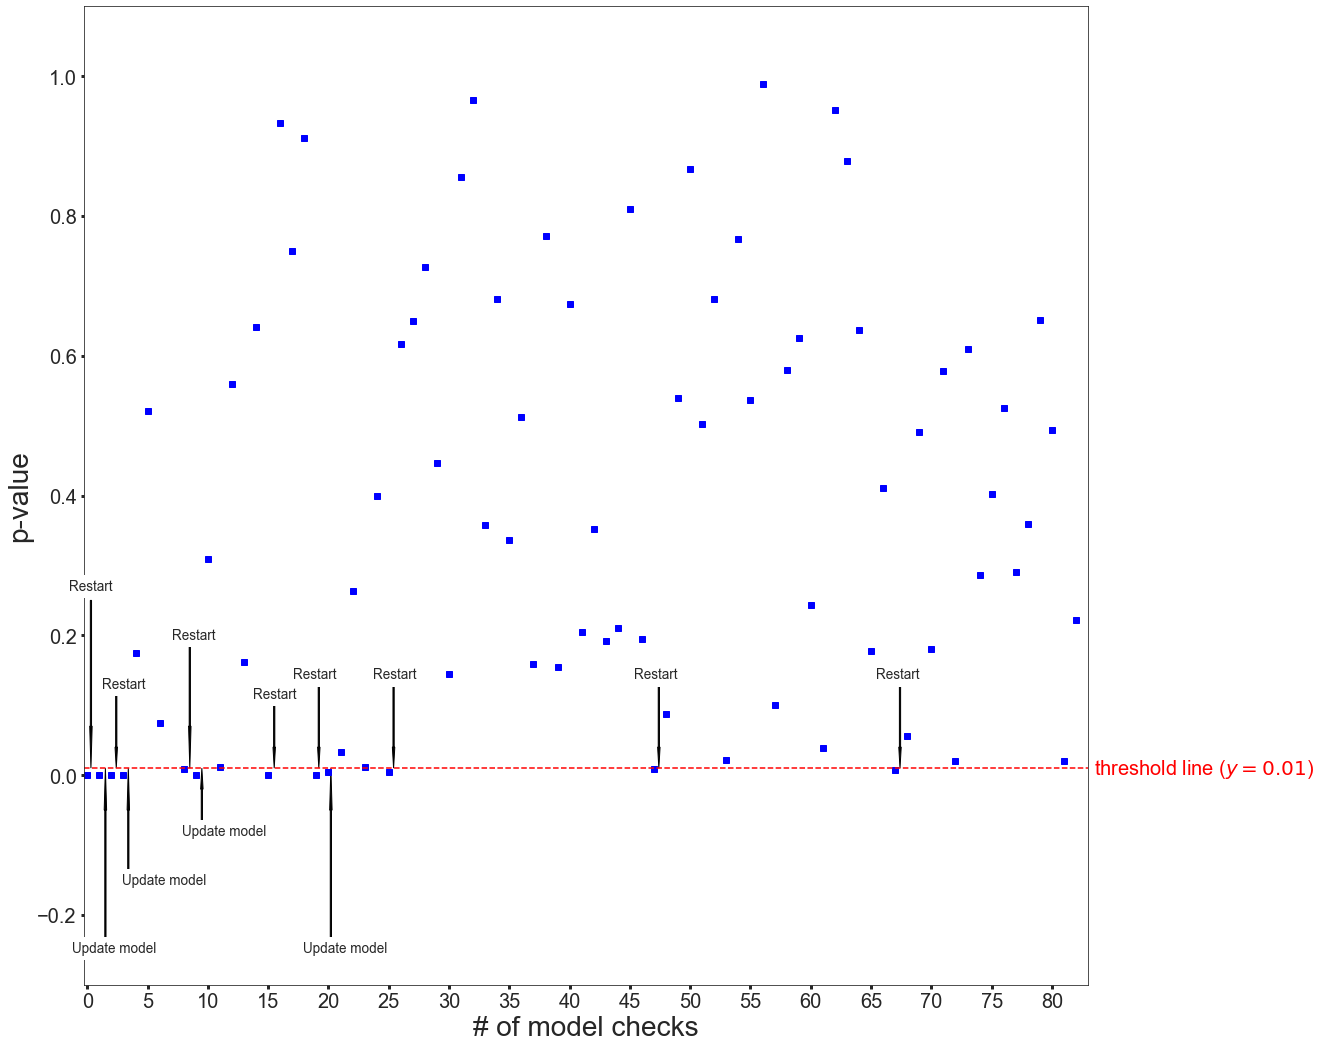

In [72]:
sns.set_style('ticks')
#plt.rcParams["pdf.use14corefonts"] = True
data_fit_vec_plot = 0.5* data_fit_vec.detach()[1:]
entropy_vec_plot = entropy_vec.detach()[1:]
p21_vec_plot = p21_vec.detach()[1:]
f, ax = plt.subplots(1, 1, figsize=(18, 18))
#ax.plot(np.array(range(2,iter+2)), torch.log(entropy_vec_plot), '+-')
#print(p21_vec_plot)
ax.plot(p21_vec_plot,'s',color = 'blue', markersize=6)
ax.axhline(.01,linestyle = '--',color = 'red', markersize=12, alpha = 1.0)
ax.set_xlim(-0.3, p21_vec_plot.shape[0])
ax.set_ylim(-0.3, 1.1)
#ax.set_yscale('log')
plt.xticks(np.arange(0, iter+10, step=5.))
ax.tick_params(labelsize='small', width=3)
ax.set_xlabel('# of model checks')
ax.set_ylabel('p-value')
ax.annotate('Update model', xy=(0.55, 0.2), xytext=(0.03, 0.03), xycoords='axes fraction', 
            fontsize=9*1.5, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'))
ax.arrow(1.5,        #x start point
             -0.25,                      #y start point
             0,       #change in x 
             0.2,                      #change in y
             head_width=0.2,         #arrow head width
             head_length=0.06,        #arrow head length
             width=0.1,              #arrow stem width
             fc='black',             #arrow fill color
             ec='black')             #arrow edge color

ax.annotate('Restart', xy=(0.55, 0.2), xytext=(0.007, 0.4), xycoords='axes fraction', 
            fontsize=9*1.5, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'))
ax.arrow(0.3,        #x start point
             0.25,                      #y start point
             0,       #change in x 
             -0.18,                      #change in y
             head_width=0.2,         #arrow head width
             head_length=0.06,        #arrow head length
             width=0.1,              #arrow stem width
             fc='black',             #arrow fill color
             ec='black') 


#############################
ax.annotate('Update model', xy=(0.55, 0.2), xytext=(0.08, 0.1), xycoords='axes fraction', 
            fontsize=9*1.5, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'))
ax.arrow(3.4,        #x start point
             -0.15,                      #y start point
             0,       #change in x 
             0.1,                      #change in y
             head_width=0.2,         #arrow head width
             head_length=0.06,        #arrow head length
             width=0.1,              #arrow stem width
             fc='black',             #arrow fill color
             ec='black')             #arrow edge color


ax.annotate('Restart', xy=(0.55, 0.15), xytext=(0.04, 0.3), xycoords='axes fraction', 
            fontsize=9*1.5, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'))
ax.arrow(2.4,        #x start point
             0.12,                      #y start point
             0,       #change in x 
             -0.08,                      #change in y
             head_width=0.2,         #arrow head width
             head_length=0.03,        #arrow head length
             width=0.1,              #arrow stem width
             fc='black',             #arrow fill color
             ec='black') 

###############################################
ax.annotate('Update model', xy=(0.55, 0.2), xytext=(0.14, 0.15), xycoords='axes fraction', 
            fontsize=9*1.5, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'))
ax.arrow(9.5,        #x start point
             -0.09,                      #y start point
             0,       #change in x 
             0.07,                      #change in y
             head_width=0.2,         #arrow head width
             head_length=0.03,        #arrow head length
             width=0.1,              #arrow stem width
             fc='black',             #arrow fill color
             ec='black')             #arrow edge color


ax.annotate('Restart', xy=(0.55, 0.15), xytext=(0.11, 0.35), xycoords='axes fraction', 
            fontsize=9*1.5, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'))
ax.arrow(8.5,        #x start point
             0.2,                      #y start point
             0,       #change in x 
             -0.13,                      #change in y
             head_width=0.2,         #arrow head width
             head_length=0.06,        #arrow head length
             width=0.1,              #arrow stem width
             fc='black',             #arrow fill color
             ec='black') 

###############################################


ax.annotate('Restart', xy=(0.55, 0.15), xytext=(0.19, 0.29), xycoords='axes fraction', 
            fontsize=9*1.5, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'))
ax.arrow(15.5,        #x start point
             0.12,                      #y start point
             0,       #change in x 
             -0.08,                      #change in y
             head_width=0.2,         #arrow head width
             head_length=0.03,        #arrow head length
             width=0.1,              #arrow stem width
             fc='black',             #arrow fill color
             ec='black') 
#############################
ax.annotate('Restart', xy=(0.55, 0.15), xytext=(0.23, 0.31), xycoords='axes fraction', 
            fontsize=9*1.5, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'))
ax.arrow(19.2,        #x start point
             0.13,                      #y start point
             0,       #change in x 
             -0.09,                      #change in y
             head_width=0.2,         #arrow head width
             head_length=0.03,        #arrow head length
             width=0.1,              #arrow stem width
             fc='black',             #arrow fill color
             ec='black') 

#############

ax.annotate('Update model', xy=(0.55, 0.2), xytext=(0.26, 0.03), xycoords='axes fraction', 
            fontsize=9*1.5, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'))
ax.arrow(20.2,        #x start point
             -0.25,                      #y start point
             0,       #change in x 
             0.2,                      #change in y
             head_width=0.2,         #arrow head width
             head_length=0.06,        #arrow head length
             width=0.1,              #arrow stem width
             fc='black',             #arrow fill color
             ec='black')             #arrow edge color



#############################
ax.annotate('Restart', xy=(0.55, 0.15), xytext=(0.31, 0.31), xycoords='axes fraction', 
            fontsize=9*1.5, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'))
ax.arrow(25.4,        #x start point
             0.13,                      #y start point
             0,       #change in x 
             -0.09,                      #change in y
             head_width=0.2,         #arrow head width
             head_length=0.03,        #arrow head length
             width=0.1,              #arrow stem width
             fc='black',             #arrow fill color
             ec='black') 

#############################
ax.annotate('Restart', xy=(0.55, 0.15), xytext=(0.57, 0.31), xycoords='axes fraction', 
            fontsize=9*1.5, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'))
ax.arrow(47.4,        #x start point
             0.13,                      #y start point
             0,       #change in x 
             -0.09,                      #change in y
             head_width=0.2,         #arrow head width
             head_length=0.03,        #arrow head length
             width=0.1,              #arrow stem width
             fc='black',             #arrow fill color
             ec='black') 


#############################
ax.annotate('Restart', xy=(0.55, 0.15), xytext=(0.81, 0.31), xycoords='axes fraction', 
            fontsize=9*1.5, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'))
ax.arrow(67.4,        #x start point
             0.13,                      #y start point
             0,       #change in x 
             -0.09,                      #change in y
             head_width=0.2,         #arrow head width
             head_length=0.03,        #arrow head length
             width=0.1,              #arrow stem width
             fc='black',             #arrow fill color
             ec='black') 
##########
# ax.annotate('Restart', xy=(0.55, 0.15), xytext=(0.48, 0.3), xycoords='axes fraction', 
#             fontsize=9*1.5, ha='center', va='bottom',
#             bbox=dict(boxstyle='square', fc='white'))
# ax.arrow(29.5,        #x start point
#              0.12,                      #y start point
#              0,       #change in x 
#              -0.08,                      #change in y
#              head_width=0.2,         #arrow head width
#              head_length=0.03,        #arrow head length
#              width=0.1,              #arrow stem width
#              fc='black',             #arrow fill color
#              ec='black') 


################################

ax.annotate('threshold line ($y = 0.01$)', xy=(1.0,0.01), xytext=(6,0), color='red', 
                xycoords = ax.get_yaxis_transform(), textcoords="offset points",
                size=14, fontsize = 20, va="center")



#ax.legend(['p-value', 'p-value Threshold ($0.01$)'], loc = 'lower right')
plt.savefig('figures/qvalue_fail.pdf',dpi=300, bbox_inches='tight')
plt.show()

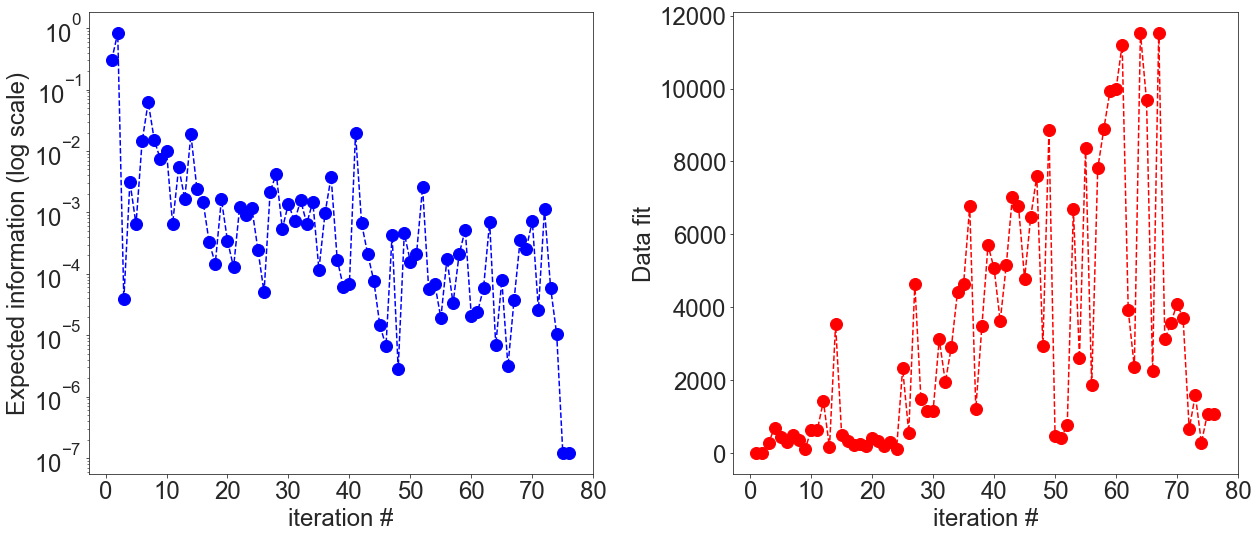

In [25]:
sns.set_style('ticks')
data_fit_vec_plot = 0.5* data_fit_vec.detach()[1:]
entropy_vec_plot = entropy_vec.detach()[1:]
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(18, 8), tight_layout=True)

ax1.plot(np.array(range(1,iter+2)), (entropy_vec_plot), '--o', color = 'blue', markersize=12)
#ax1.set_yscale('log')
# ax.plot(np.array(data_fit_vec_plot), (entropy_vec_plot), 'o')
ax1.set_yscale('log')

ax2.plot(np.array(range(1,iter+2)), data_fit_vec_plot, '--o', color = 'red', markersize=12)

ax1.set_xlabel('iteration #', size=24)
ax2.set_xlabel('iteration #', size=24)
ax1.set_xticks(np.arange(0,iter+15, step=10.))
ax1.set_ylabel('Expected information (log scale)', size = 24)
ax2.set_ylabel('Data fit', size = 24)
ax2.set_xticks(np.arange(0,iter+15, step=10.))
#ax2.yfmt.set_useOffset(10000)

plt.savefig('figures_Carlo/expectedinfo_vs_datafit_fail.pdf',dpi=300, bbox_inches='tight')
plt.show()

In [17]:
torch.save(vec_x, 'data_plots/vec_x_fail.txt')
torch.save(g_theta2, 'data_plots/g_theta2_fail.txt')
torch.save(g_theta1, 'data_plots/g_theta1_fail.txt')
torch.save(x_train, 'data_plots/x_train_ini_fail.txt')
torch.save(y_train, 'data_plots/y_train_ini_fail.txt')
torch.save(entropy_vec_plot, 'data_plots/entropy_vec_fail.txt')
torch.save(data_fit_vec_plot, 'data_plots/datafit_fail.txt')
torch.save(p21_vec_plot, 'data_plots/p21_vec_fail.txt')
torch.save(loss, 'data_plots/loss_fail.txt')
torch.save(pf1, 'data_plots/pf1_success.txt')
torch.save(Qf1.evaluate(), 'data_plots/Qf1_fail.txt')
torch.save(Qf12.evaluate(), 'data_plots/Qf12_fail.txt')
torch.save(Q21.evaluate(), 'data_plots/Q21_fail.txt')
torch.save(iter+1, 'data_plots/iter_fail.txt')

In [18]:
v2 = g_theta2_vec.reshape(math.ceil(g_theta2_vec.shape[0]/2),2)
torch.save(v2, 'data_plots/v2_fail.txt')

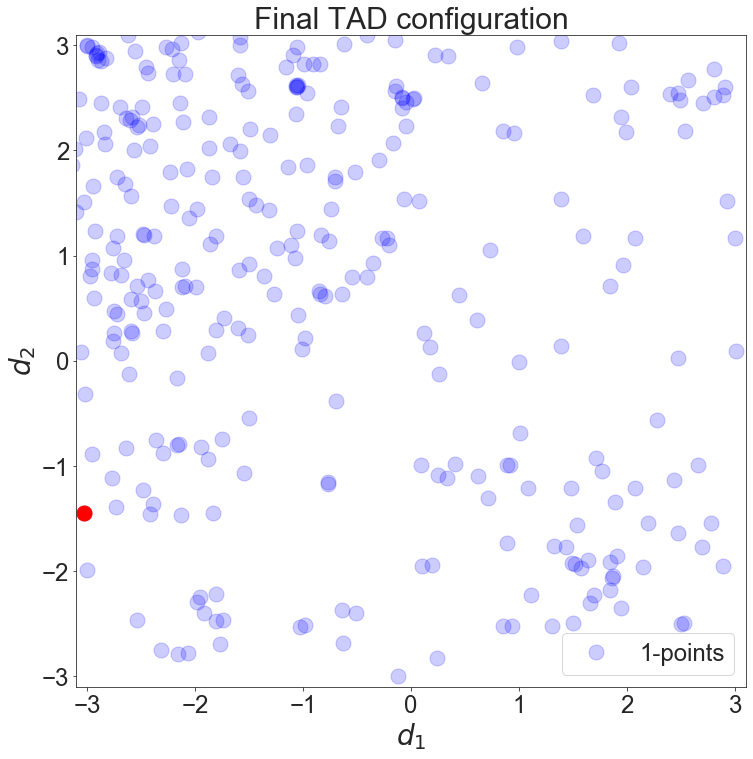

In [19]:
fig, ax = plt.subplots(figsize = (12,12))
ax.set_xlim(-3.1, 3.1)
ax.set_ylim(-3.1, 3.1)
#ax.scatter(g_theta1[:, 0].detach(),g_theta1[:, 1].detach(), c="b", alpha=0.8)
ax.plot(g_theta1[:, 0].detach(),g_theta1[:, 1].detach() , 'o', color = 'blue',markersize=15, alpha = 0.2)
ax.plot(vec_x[-1,0], vec_x[-1,1],'o', color = 'red',markersize=15)
#ax.plot(0.8731, 0.5664,'go', color = 'green',markersize=15)
ax.set_title('Final TAD configuration')
ax.set_xlabel('$d_1$')
ax.set_ylabel('$d_2$')
ax.legend(['1-points'])
plt.savefig('figures/tad_sol_allpoints_fail.pdf')
plt.show()

In [20]:
sleep

NameError: name 'sleep' is not defined

In [73]:
x_plot = np.linspace(-3.1, 3.1, 30)
y_plot = np.linspace(-3.1, 3.1, 30)
xv_plot, yv_plot = np.meshgrid(x_plot, y_plot)
n = x_plot.shape[0]
x_concat_ = torch.zeros(n * n, 2)
training_param_iter = 200

# n_sample = x_concat_.shape[0]
num_tasks = 2
i = 0
k = 0
while i < n*n:
    x_concat_[i:i+n,0] = Tensor(xv_plot[:,k])
    x_concat_[i:i+n,1] = Tensor(y_plot)
    k = k+1
    i = i+n

#dis_2sample = MultivariateNormal( loc = x0, covariance_matrix= .01 * torch.eye(2) )
                    #loc_size = 4
loc_sample = 1./3. * Tensor(high_minus_low  * np.random.random_sample((3,2)) + vf.low) # #dis_2sample.sample((2 + 1,))
loc_sample0 = loc_sample.reshape(2 + 1, 2)
g2 = g_theta2.detach() #loc_sample0 #Tensor(loc_sample) #.detach()
likelihood.eval()
model.eval()
plot = [1, 6, 12, 17, 30, 35, 38, 56, 76]
zz = torch.zeros(n*n, 9)
kk = 0
for jj in plot:
    try:
        
        PATH = ".//model_Carlo/model_goodmodel/model_fail_"+str(jj - 1)+".pt"
        model_16 = torch.load(PATH)
    except:
        PATH = ".//model_Carlo/model_update/model_fail_"+str(jj - 1)+".pt"
        model_16 = torch.load(PATH)
   # model_16 = torch.load(PATH)
    model_16.eval()

    likelihood.eval()
    g2 = v2.detach()[jj - 1 +loc_size+1 : jj - 1 +loc_size+1 +loc_size+1]
    g_theta1_cur = g_theta1[0:(4 + (jj - 1)* 3)]
    agg_data_cur = agg_data[0:2 * (4 + (jj - 1)* 3)]
    print(agg_data_cur.shape)
    for ii in range(n*n):
        print(ii)
        x0 = x_concat_[ii,:].reshape(1,2)
    #     dis_2sample = MultivariateNormal( loc = x0, covariance_matrix= .001 * torch.eye(2) )
    #                     #loc_size = 4
    #     loc_sample = dis_2sample.sample((2 + 1,))
    #     loc_sample0 = loc_sample.reshape(2 + 1, 2)
        #g2 = loc_sample0 #Tensor(loc_sample) #.detach()


        
        loss2_, pf1_, Qf1_, Qf12_, data_fit_, Q21_ = likelihood.get_ell(agg_data_cur,f_target,x0, g_theta1_cur, model_16, likelihood, noise_value, g2)
        zz[ii, kk] = loss2_
    kk = kk+1
zz = zz.reshape(n,n, 9)
torch.save(zz, 'data_plots/zz_fail.txt')

torch.Size([8])
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
27

321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570


616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864
865


12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283


In [74]:
import matplotlib.ticker
class OOMFormatter(matplotlib.ticker.ScalarFormatter):
    def __init__(self, order=0, fformat="%1.1f", offset=True, mathText=True):
        self.oom = order
        self.fformat = fformat
        matplotlib.ticker.ScalarFormatter.__init__(self,useOffset=offset,useMathText=mathText)
    def _set_order_of_magnitude(self):
        self.orderOfMagnitude = self.oom
    def _set_format(self, vmin=None, vmax=None):
        self.format = self.fformat
        if self._useMathText:
             self.format = r'$\mathdefault{%s}$' % self.format

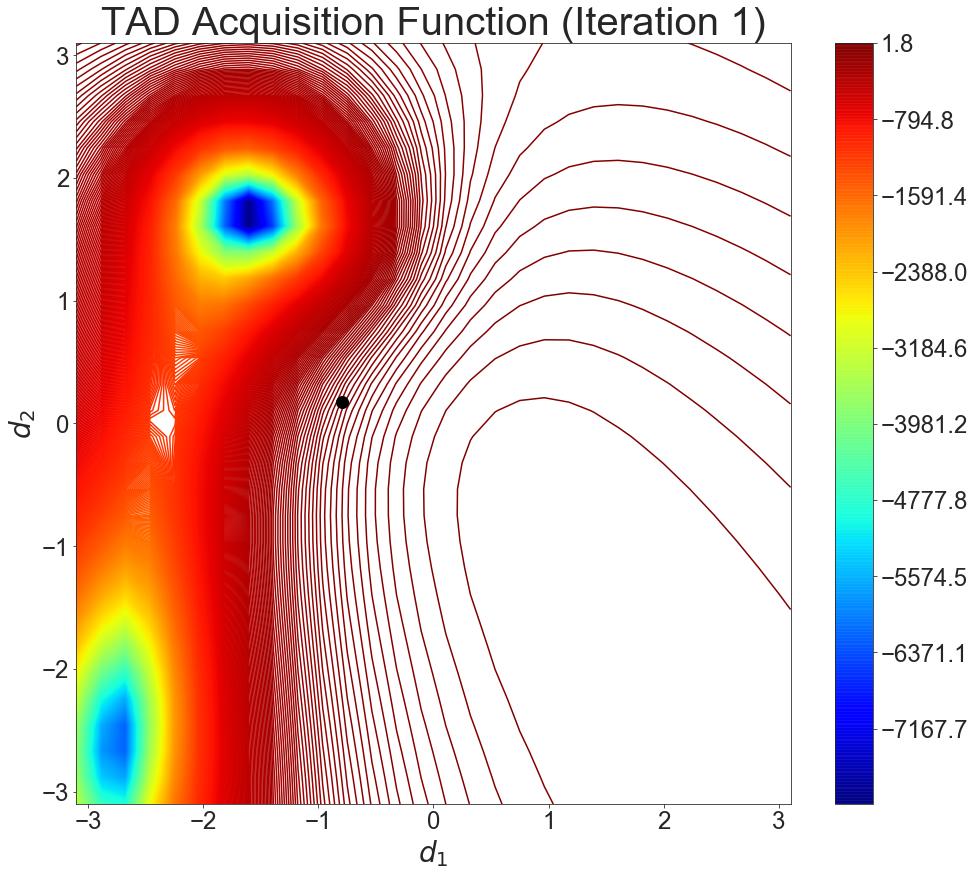

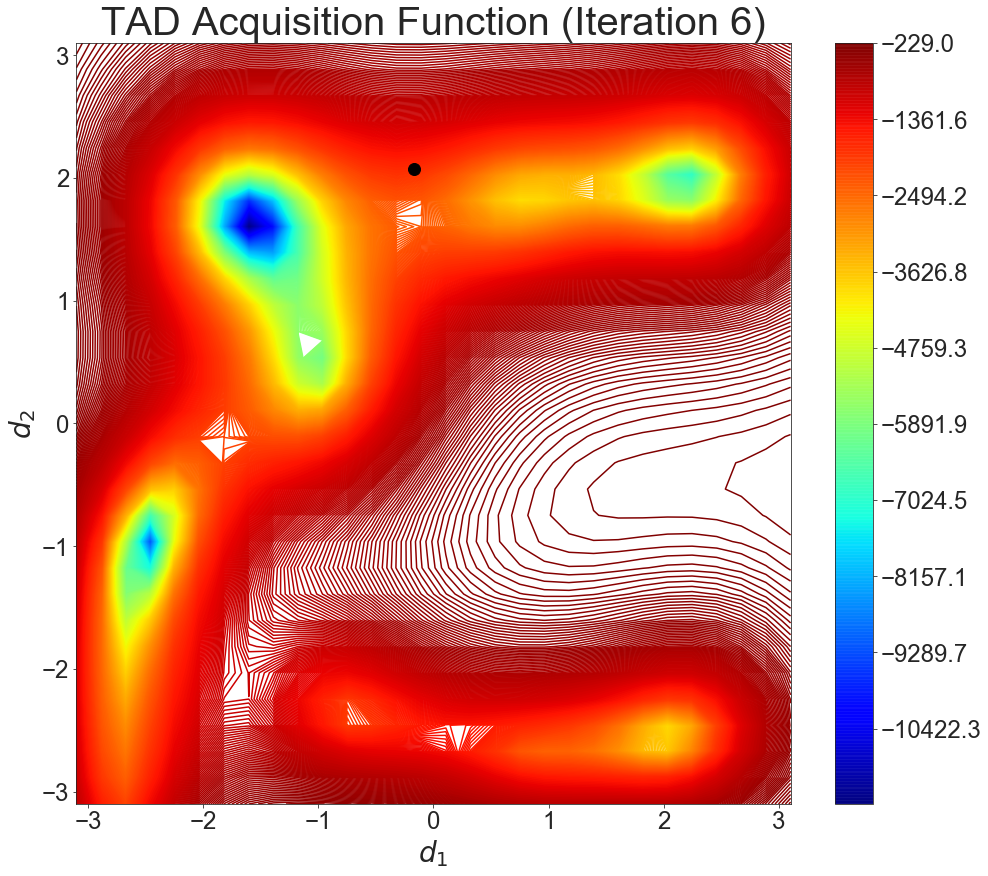

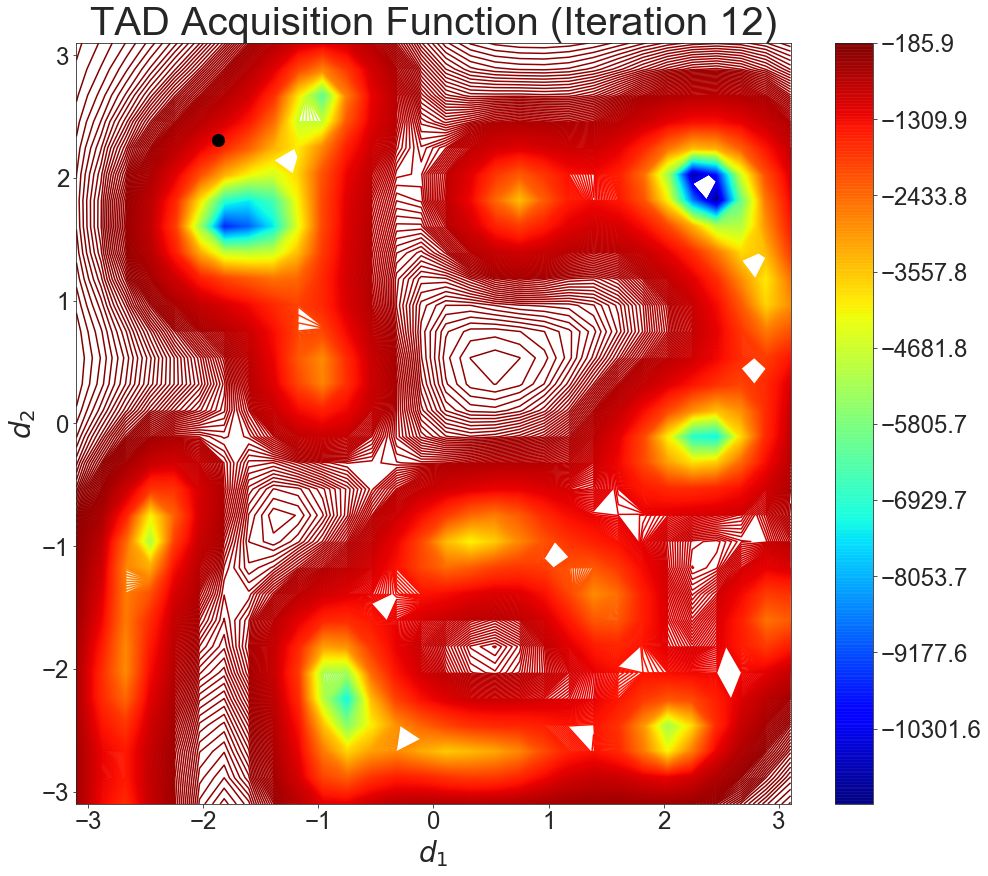

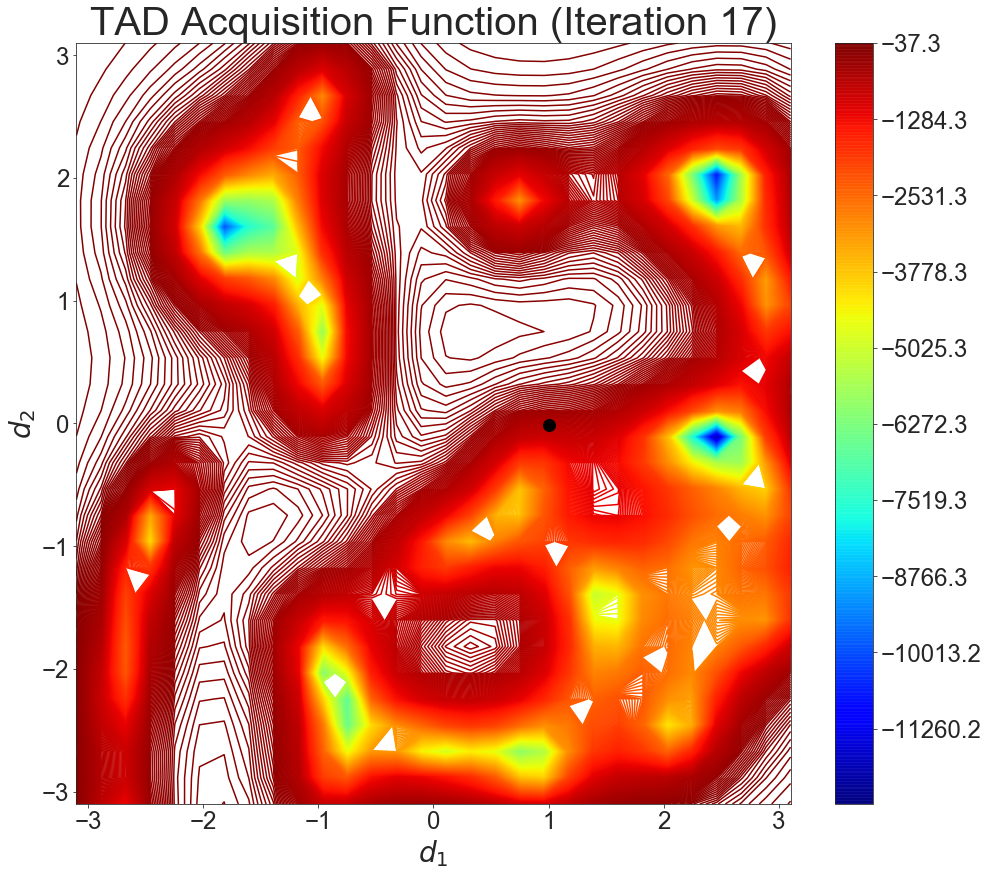

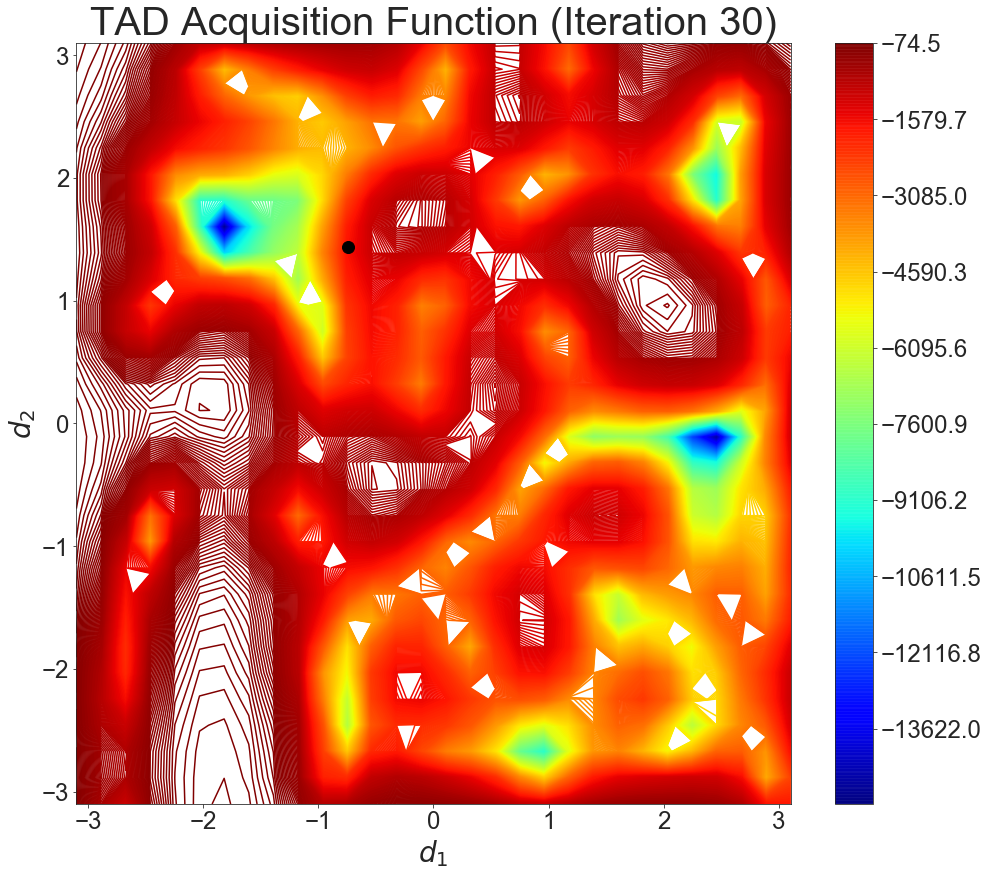

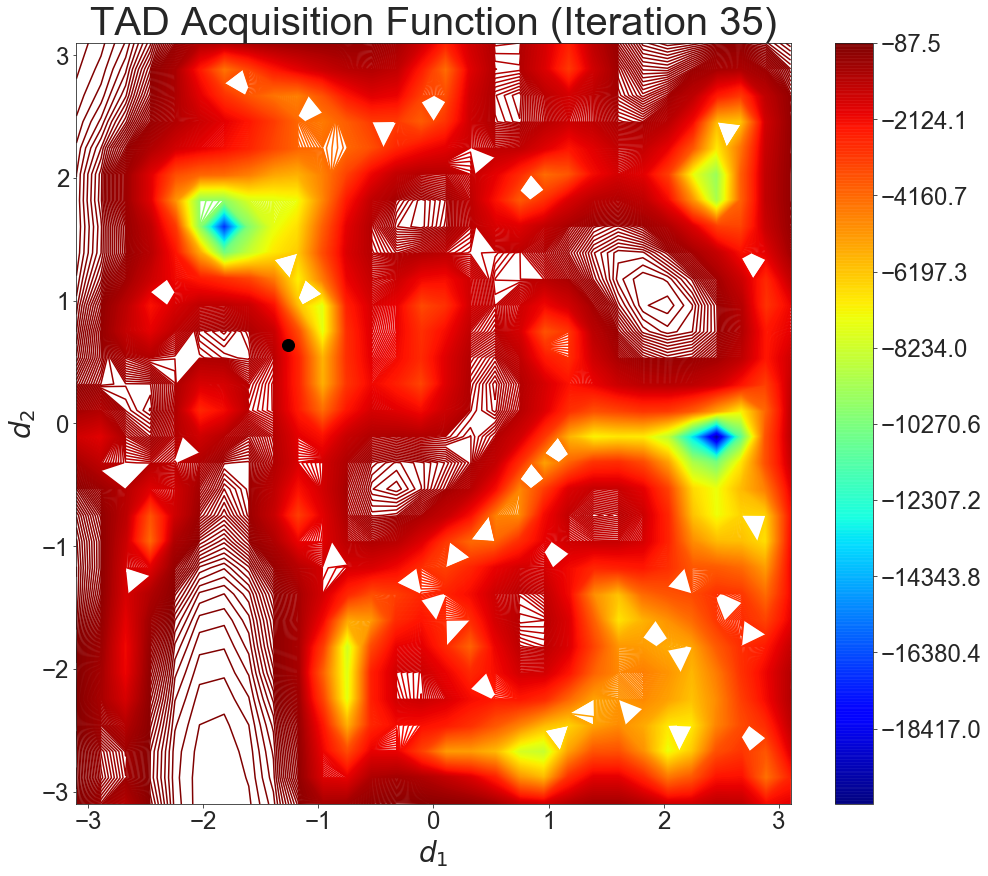

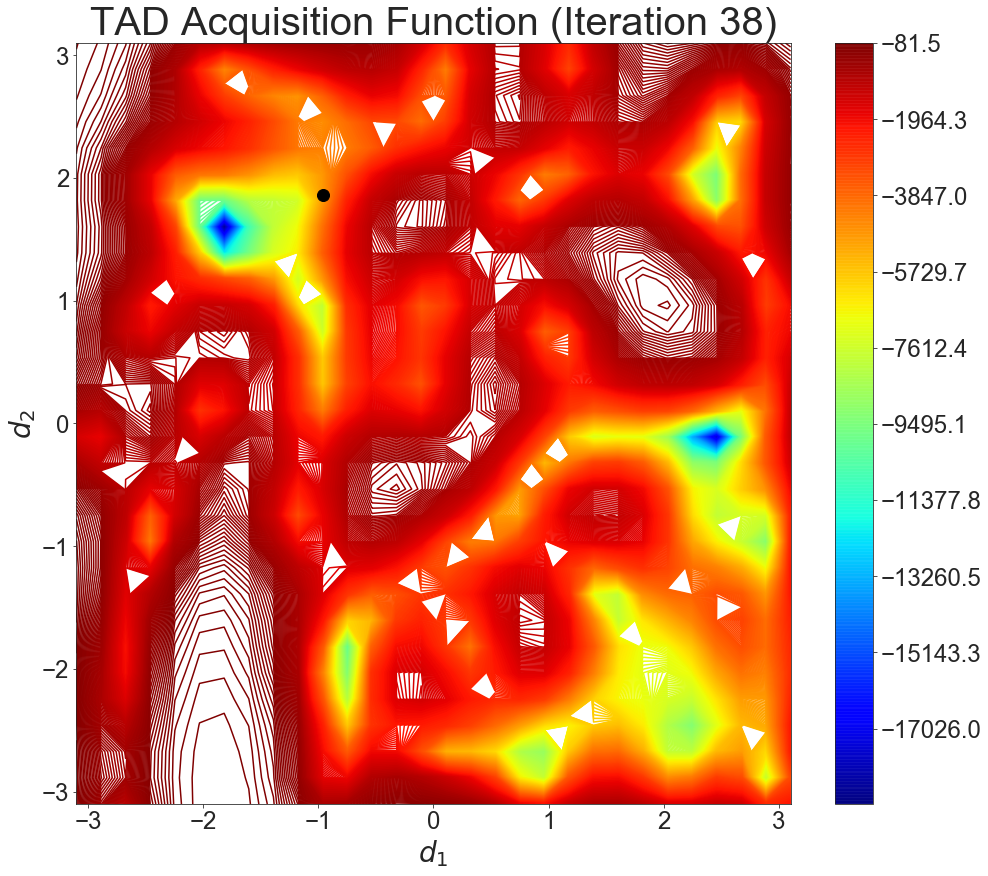

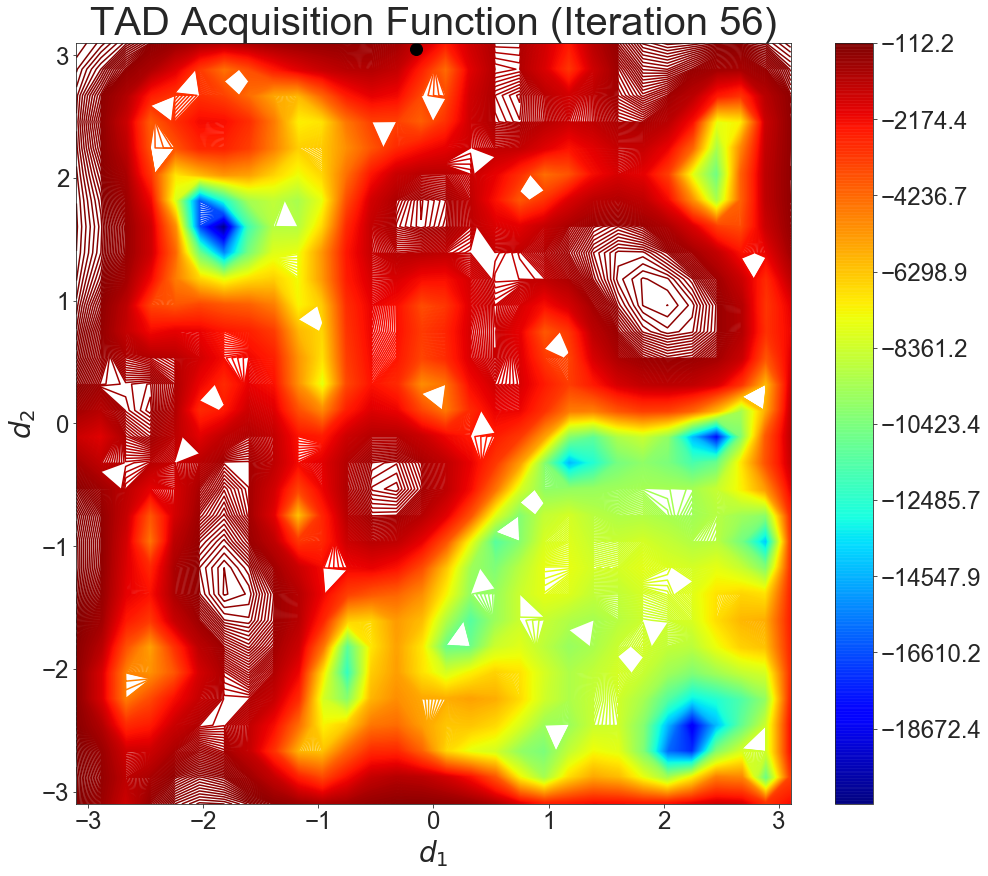

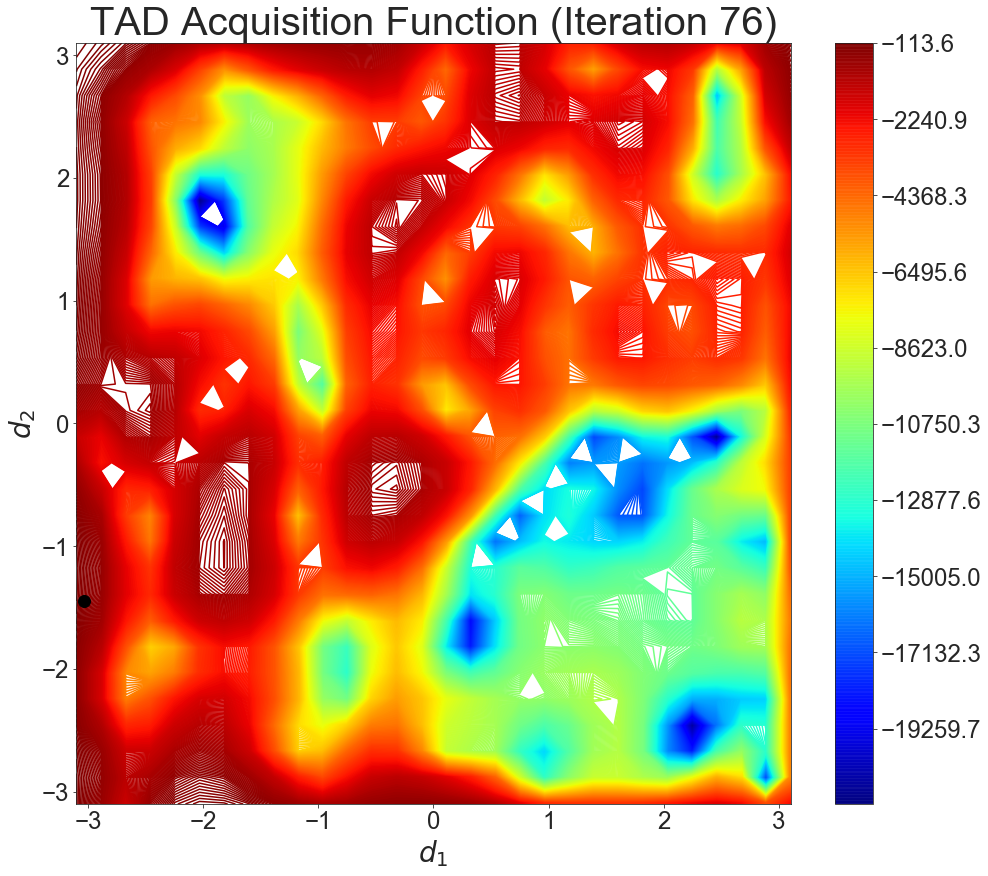

In [75]:
for jj in range(9):
    fig, ax = plt.subplots(figsize = (16,14))
    #
    cs = ax.contour(xv_plot, yv_plot,  zz[:,:,jj].detach(), np.linspace( zz[:,:,jj].detach().numpy().min(), zz[:,:,jj].detach().numpy().max(), 1000), cmap = 'jet')
    cbar = fig.colorbar(cs, ax = ax,format=OOMFormatter(0, mathText=False));
    #ax.plot(vf.tgt_loc[0,0],vf.tgt_loc[0,1], 'o', color = 'magenta', markersize=12)
    kk = plot[jj]
    if kk < plot[8]:
        ax.plot(vec_x[kk,0], vec_x[kk,1],'o', color = 'black',markersize=12)
    if kk == plot[8]:
        ax.plot(vec_x[- 1,0], vec_x[- 1,1],'o', color = 'black',markersize=12)
    ax.set_title('TAD Acquisition Function (Iteration '+str(kk)+')', fontsize = 40)
    ax.set_xlabel('$d_1$')
    ax.set_ylabel('$d_2$')
    
    
    plt.savefig('figures_Carlo/tad_obj_fail'+str(kk)+'.pdf', dpi=300, bbox_inches='tight')

## 

In [ ]:
vec_x